
# 🏦 Banvic - EDA & Métricas
##### | Elaborado por Julia Leandro
#### =============================================================

## Conteúdo do Notebook
- Inicial
    - Importação das bibiliotecas
    - Leitura dos dados
    - Limpeza e Conversão de Tipos (casting) + API Dólar
    - Features/Derivações
- Dimensão de Datas (dim_dates)
- Análise das Agências
- Análise dos Clientes
- Análise dos Colaboradores
- Análise das Contas
- Análise das Propostas de Crédito
- Análise das Transações
- Integração com Dados Externos - Cotação Dólar USD
- KPIs
- Exportações de csv

#### =============================================================

#### Importação das Bibliotecas

In [431]:
# Dados e Manipulação
import pandas as pd # Manipulação de dados
import seaborn as sns # Visualização de dados
import matplotlib.pyplot as plt # Visualização de dados
import matplotlib.ticker as mtick # Formatação de Gráficos e Números 
import numpy as np # Manipulação de dados (par e ímpar)

# Tradução de meses
import locale 
locale.setlocale(locale.LC_TIME, "pt_BR.UTF-8")

# Manipulação de Datas
from datetime import datetime, timedelta # Manipulação de datas
from pandas.tseries.offsets import DateOffset # Manipulação de datas
from pandas.api.types import is_datetime64tz_dtype # Verificação de tipo de dado datetime com timezone

# Cotação do Dólar
import requests # Requisições HTTP  

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#### Leitura dos Dados (csv)

In [432]:
agencias = pd.read_csv("../dados/agencias.csv")
clientes = pd.read_csv("../dados/clientes.csv")
colaborador_agencia = pd.read_csv("../dados/colaborador_agencia.csv")
colaboradores = pd.read_csv("../dados/colaboradores.csv")
contas = pd.read_csv("../dados/contas.csv")
propostas_credito = pd.read_csv("../dados/propostas_credito.csv")
transacoes = pd.read_csv("../dados/transacoes.csv")

#### Limpeza e Conversão de Tipos (Casting) + API Dólar

##### Conversões

In [433]:
# Conversão datas
clientes["data_nascimento"] = pd.to_datetime(clientes["data_nascimento"], errors="coerce")
propostas_credito["data_entrada_proposta"] = pd.to_datetime(propostas_credito["data_entrada_proposta"], errors="coerce")
contas["data_abertura"] = pd.to_datetime(contas["data_abertura"], errors="coerce")
contas["data_ultimo_lancamento"] = pd.to_datetime(contas["data_ultimo_lancamento"], errors="coerce")

# Conversão numérica
transacoes["valor_transacao"] = pd.to_numeric(transacoes["valor_transacao"], errors="coerce")
propostas_credito["valor_proposta"] = pd.to_numeric(propostas_credito["valor_proposta"], errors="coerce")
propostas_credito["valor_financiamento"] = pd.to_numeric(propostas_credito["valor_financiamento"], errors="coerce")

##### Remoção de duplicatas

In [434]:
clientes = clientes.drop_duplicates("cod_cliente") 
contas = contas.drop_duplicates("num_conta") 
propostas_credito = propostas_credito.drop_duplicates("cod_proposta")
transacoes = transacoes.drop_duplicates("cod_transacao")

##### Parsing da coluna data_transacao (ajuste de timezone)

Padronização no formato datetime para evitar futuros erros 

In [435]:
# Renomeando a coluna original para preservar os dados brutos
if "data_transacao_raw" not in transacoes.columns:
    transacoes = transacoes.rename(columns={"data_transacao": "data_transacao_raw"})

# Convertendo direto para datetime 
s = transacoes["data_transacao_raw"].astype(str).str.strip()
dt = pd.to_datetime(s, utc=True, errors="coerce")

In [436]:
# FALLBACKS

# 1° Fallback: Tratamento de strings que terminam com "UTC"
mask = dt.isna()
if mask.any():
    s_fix = s[mask].str.replace(r"\sUTC$", "+00:00", regex=True)
    dt2 = pd.to_datetime(s_fix, utc=True, errors="coerce")
    dt[mask] = dt2

# 2° Fallback: Conversão de datas em formato dia/mês/ano
mask = dt.isna()
if mask.any():
    dt3 = pd.to_datetime(s[mask], dayfirst=True, utc=True, errors="coerce")
    dt[mask] = dt3

In [437]:
# Ajustando a timezone para America/Sao_Paulo e remove a info de fuso
dt_local = dt.dt.tz_convert("America/Sao_Paulo").dt.tz_localize(None)

In [438]:
# Salvando colunas finais no DataFrame
transacoes["data_transacao"] = dt_local
transacoes["data"] = transacoes["data_transacao"].dt.normalize()

In [439]:
# Verificação para caso existem valores inválidos (NaT)
nat_count = transacoes["data_transacao"].isna().sum()
print(f"NaT restantes em data_transacao: {nat_count}")
if nat_count:
    exemplos = transacoes.loc[transacoes["data_transacao"].isna(), "data_transacao_raw"].head(10).tolist()
    print("Exemplos não parseados:", exemplos)

NaT restantes em data_transacao: 0


##### API Dólar (Dados Cotação Dólar BCB - Banco Central do Brasil)

Request + Filtro

In [440]:
# URL
base_dados = ("https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo(dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?@dataInicial='01-01-2022'&@dataFinalCotacao='12-31-2023'&$top=100&$format=json&$select=cotacaoVenda,dataHoraCotacao")

# Requisição e parsing dos dados da API do Banco Central do Brasil (BCB)
frames = []
url = base_dados
while url:
    r = requests.get(url).json()
    frames.append(pd.DataFrame(r["value"]))
    url = r.get("@odata.nextLink") 

# Registro da última cotação do dia 
fx = pd.concat(frames, ignore_index=True)
fx["dataHoraCotacao"] = pd.to_datetime(fx["dataHoraCotacao"])
fx["data"] = fx["dataHoraCotacao"].dt.floor("D")

# Tabela diária do câmbio
fx_dia = (fx.sort_values("dataHoraCotacao")
            .groupby("data", as_index=False)
            .agg(usd_ptax=("cotacaoVenda","last")))

# Filtro do período selecionado (2022 - 2023)
fx_dia = fx_dia.query("data >= '2022-01-01' and data <= '2023-12-31'").copy()

#### Features/Derivações

In [441]:
clientes["idade"] = datetime.now().year - clientes["data_nascimento"].dt.year 

transacoes["data"] = transacoes["data_transacao"].dt.normalize()
transacoes["mes"] = transacoes["data_transacao"].dt.month
transacoes["par_impar"] = transacoes["mes"].apply(lambda x: "Par" if x % 2 == 0 else "Ímpar")
transacoes["dia_semana"] = transacoes["data_transacao"].dt.day_name()

#### =============================================================
### 📅 Dimensão de datas (`dim_dates`)

dim_dates cobre o período de 2010 a 2023

In [442]:
# Definindo o periódo mínimo e máximo do dataset
data_min = transacoes["data_transacao"].min()
data_max = transacoes["data_transacao"].max()

# Intervalo de datas
dim_dates = pd.DataFrame({"data": pd.date_range(start=data_min, end=data_max)})

# Criação das colunas da dim_dates
dim_dates["ano"] = dim_dates["data"].dt.year
dim_dates["mes"] = dim_dates["data"].dt.month
dim_dates["nome_mes"] = dim_dates["data"].dt.month_name()
dim_dates["nome_mes"] = dim_dates["data"].dt.strftime("%B")
dim_dates["dia"] = dim_dates["data"].dt.day
dim_dates["dia_semana"] = dim_dates["data"].dt.day_name()
dim_dates["par_impar"] = dim_dates["mes"].apply(lambda x: "Par" if x % 2 == 0 else "Ímpar")

dim_dates

,data,ano,mes,nome_mes,dia,dia_semana,par_impar
0,2010-02-27 13:39:46,2010,2,fevereiro,27,Saturday,Par
1,2010-02-28 13:39:46,2010,2,fevereiro,28,Sunday,Par
2,2010-03-01 13:39:46,2010,3,marÃ§o,1,Monday,Ímpar
3,2010-03-02 13:39:46,2010,3,marÃ§o,2,Tuesday,Ímpar
4,2010-03-03 13:39:46,2010,3,marÃ§o,3,Wednesday,Ímpar
...,...,...,...,...,...,...,...
4700,2023-01-10 13:39:46,2023,1,janeiro,10,Tuesday,Ímpar
4701,2023-01-11 13:39:46,2023,1,janeiro,11,Wednesday,Ímpar
4702,2023-01-12 13:39:46,2023,1,janeiro,12,Thursday,Ímpar
4703,2023-01-13 13:39:46,2023,1,janeiro,13,Friday,Ímpar


#### =============================================================
### 🪙 Agencias

#### Checagem de nulos

In [443]:
agencias.isnull().sum()

cod_agencia      0
nome             0
endereco         0
cidade           0
uf               0
data_abertura    0
tipo_agencia     0
dtype: int64

#### Exploração inicial

In [444]:
# agencias.info()
agencias.describe()
agencias.columns

Index(['cod_agencia', 'nome', 'endereco', 'cidade', 'uf', 'data_abertura',
       'tipo_agencia'],
      dtype='object')

#### Identificação do estado com mais agências

In [445]:
agencias["uf"].value_counts() 
print(f"O estado com mais agências é {agencias['uf'].value_counts().idxmax()} com {agencias['uf'].value_counts().max()} agências.")

O estado com mais agências é SP com 6 agências.


#### Ranking das Agências por volume de transações

In [446]:
# Merge transacoes com contas para obter cod_agencia
transacoes_conta = transacoes.merge(contas[["num_conta", "cod_agencia"]], on="num_conta", how="inner")

# Merge transacoes_conta com agências para obter nome da agencia
transacoes_conta_agencia = transacoes_conta.merge(agencias[["cod_agencia", "nome"]], on="cod_agencia", how="left")

# Contagem de transações por agência
transacoes_agencia = (transacoes_conta_agencia.groupby("nome")["cod_transacao"].count().sort_values(ascending=False))

In [447]:
tres_melhores = transacoes_agencia.head(3)
tres_piores = transacoes_agencia.tail(3)

print(
    f"RANKING AGÊNCIAS\n\n"
    f"Top 3 Melhores agências: {', '.join(tres_melhores.index)}\n\n"
    f"Top 3 Piores Agências: {', '.join(tres_piores.index)}"
)

RANKING AGÊNCIAS

Top 3 Melhores agências: Agência Digital, Agência Matriz, Agência Tatuapé

Top 3 Piores Agências: Agência Florianópolis, Agência Jardins, Agência Recife


Criação da base "ranking_agencias"

In [448]:
ranking_agencias = (transacoes_conta_agencia.groupby("nome", as_index=False).agg(qtd_transacoes=("cod_transacao","count"),valor_total=("valor_transacao","sum")).sort_values("qtd_transacoes", ascending=False))

#### Ranking das Agências por volume de transações (Últimos 6 MESES)

Inserindo os limites de data

In [449]:
data_max = transacoes["data_transacao"].max()
limite_6m = data_max - DateOffset(months=6)

transacoes_6m = transacoes[transacoes["data_transacao"] >= limite_6m]

Junções(merge)

In [450]:
# Merge transacoes_6m com contas para obter cod_agencia
transacoes_conta_6m = transacoes_6m.merge(contas[["num_conta", "cod_agencia"]], on="num_conta", how="inner")

# Merge transacoes_conta_6m com agencias para obter nome da agencia
transacoes_conta_agencia_6m = transacoes_conta_6m.merge(agencias[["cod_agencia", "nome"]], on="cod_agencia", how="left")

Rankeando as agências (6 meses)

In [451]:
qtde_6m = (transacoes_conta_agencia_6m.groupby("nome")["cod_transacao"].count().sort_values(ascending=False))
valor_6m = (transacoes_conta_agencia_6m.groupby("nome")["valor_transacao"].sum().sort_values(ascending=False))

tres_melhores_6m = qtde_6m.head(3)
tres_piores_6m = qtde_6m.tail(3)

print(
    f"RANKING AGÊNCIAS (6 meses)\n\n"
    f"Top 3 Melhores agências: {', '.join(tres_melhores_6m.index)}\n\n"
    f"Top 3 Piores Agências: {', '.join(tres_piores_6m.index)}"
)

RANKING AGÊNCIAS (6 meses)

Top 3 Melhores agências: Agência Digital, Agência Matriz, Agência Tatuapé

Top 3 Piores Agências: Agência Florianópolis, Agência Jardins, Agência Recife


Criação da base "ranking_agencias_6m"

In [452]:

ranking_agencias_6m = (transacoes_conta_agencia_6m.groupby("nome", as_index=False).agg(qtd_transacoes=("cod_transacao","count"),valor_total=("valor_transacao","sum")).sort_values("qtd_transacoes", ascending=False))

#### =============================================================
### 🚹 Clientes

#### Checagem de nulos

In [453]:
clientes.isnull().sum()

cod_cliente        0
primeiro_nome      0
ultimo_nome        0
email              0
tipo_cliente       0
data_inclusao      0
cpfcnpj            0
data_nascimento    0
endereco           0
cep                0
idade              0
dtype: int64

#### Exploração inicial 

In [454]:
# clientes.info()
clientes.describe()
clientes.columns

Index(['cod_cliente', 'primeiro_nome', 'ultimo_nome', 'email', 'tipo_cliente',
       'data_inclusao', 'cpfcnpj', 'data_nascimento', 'endereco', 'cep',
       'idade'],
      dtype='object')

#### Análise de distribuição por idade


In [455]:
clientes["data_nascimento"] = pd.to_datetime(clientes["data_nascimento"])

clientes["idade"].describe() # Faixa etária

count    998.000000
mean      50.929860
std       18.757896
min       18.000000
25%       35.000000
50%       51.000000
75%       68.000000
max       83.000000
Name: idade, dtype: float64

Visualização dos dados

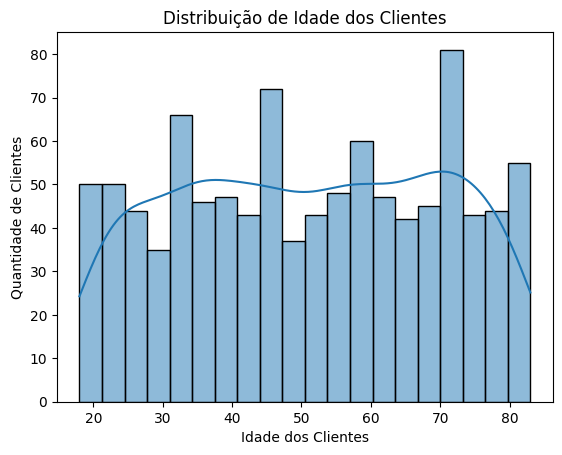

In [456]:
sns.histplot(data=clientes, x="idade", bins=20, kde=True)
plt.title("Distribuição de Idade dos Clientes")
plt.xlabel("Idade dos Clientes")
plt.ylabel("Quantidade de Clientes")
plt.show()

####  Concentração de clientes por estado

In [457]:
clientes["estado"] = clientes["endereco"].str.split("/").str[-1].str.strip()
clientes["estado"].value_counts()
print(f"O estado com mais clientes é {clientes['estado'].value_counts().idxmax()} com {clientes['estado'].value_counts().max()} clientes.")

O estado com mais clientes é AM com 53 clientes.


#### Junções (merge)

Junção de tabela ``clientes`` com ``propostas_credito``

In [458]:
cliente_credito = pd.merge(clientes, propostas_credito, on="cod_cliente")
cliente_credito

,cod_cliente,primeiro_nome,ultimo_nome,email,tipo_cliente,data_inclusao,cpfcnpj,data_nascimento,endereco,cep,...,cod_colaborador,data_entrada_proposta,taxa_juros_mensal,valor_proposta,valor_financiamento,valor_entrada,valor_prestacao,quantidade_parcelas,carencia,status_proposta
0,28,Sabrina,Dias,moreiraemanuelly@example.org,PF,2017-04-03 16:11:00 UTC,357.081.496-39,2006-08-11,Praia de Duarte Vila Piratininga 81327-166 Fer...,95140-704,...,17,2015-04-03 04:34:11+00:00,0.0106,13056.935827,18009.22,4952.284173,285.157078,63,3,Enviada
1,28,Sabrina,Dias,moreiraemanuelly@example.org,PF,2017-04-03 16:11:00 UTC,357.081.496-39,2006-08-11,Praia de Duarte Vila Piratininga 81327-166 Fer...,95140-704,...,73,2010-09-02 22:06:54+00:00,0.0212,68031.962747,110541.92,42509.957253,1910.887012,67,6,Enviada
2,28,Sabrina,Dias,moreiraemanuelly@example.org,PF,2017-04-03 16:11:00 UTC,357.081.496-39,2006-08-11,Praia de Duarte Vila Piratininga 81327-166 Fer...,95140-704,...,87,2018-05-30 16:04:13+00:00,0.0132,139839.834712,240449.39,100609.555288,2861.303123,79,5,Aprovada
3,674,Luiz Felipe,Dias,pedroferreira@example.org,PF,2021-02-10 13:27:00 UTC,085.196.374-93,1995-10-11,"Avenida da Rosa, 654 João Paulo Ii 20295449 Nu...",76516-765,...,29,2020-07-24 15:00:23+00:00,0.0210,94843.853223,140271.31,45427.456777,2363.479287,89,1,Enviada
4,674,Luiz Felipe,Dias,pedroferreira@example.org,PF,2021-02-10 13:27:00 UTC,085.196.374-93,1995-10-11,"Avenida da Rosa, 654 João Paulo Ii 20295449 Nu...",76516-765,...,34,2022-04-23 03:15:25+00:00,0.0236,15301.504986,19535.75,4234.245014,4053.705326,4,3,Aprovada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,845,Pedro Lucas,da Conceição,silveirabruno@example.com,PF,2020-12-16 15:14:00 UTC,347.028.591-88,1943-12-12,"Travessa Eloah Moura, 97 Alta Tensão 2ª Seção ...",36211-005,...,38,2012-07-14 02:25:07+00:00,0.0099,149926.136028,217880.51,67954.373972,2328.324613,103,1,Validação documentos
1992,853,Milena,da Conceição,ribeirodanilo@example.net,PF,2020-11-21 11:32:00 UTC,870.534.912-50,1999-04-22,"Feira de Vieira, 1 Planalto 31794137 Rodrigues...",15386938,...,16,2012-06-05 20:29:13+00:00,0.0131,30487.987981,52975.78,22487.792019,823.338389,51,0,Enviada
1993,853,Milena,da Conceição,ribeirodanilo@example.net,PF,2020-11-21 11:32:00 UTC,870.534.912-50,1999-04-22,"Feira de Vieira, 1 Planalto 31794137 Rodrigues...",15386938,...,18,2011-02-18 11:55:27+00:00,0.0087,133575.197230,228888.78,95313.582770,2247.992311,84,2,Enviada
1994,853,Milena,da Conceição,ribeirodanilo@example.net,PF,2020-11-21 11:32:00 UTC,870.534.912-50,1999-04-22,"Feira de Vieira, 1 Planalto 31794137 Rodrigues...",15386938,...,35,2015-10-30 01:22:06+00:00,0.0152,52439.145420,98620.47,46181.324580,964.731237,116,1,Aprovada


Junção da coluna ``idade`` com ``status_proposta``


In [459]:
idade_status = pd.merge(clientes[["cod_cliente","idade"]], propostas_credito[["cod_cliente","status_proposta"]], on="cod_cliente", how="inner")
idade_status

,cod_cliente,idade,status_proposta
0,28,19,Enviada
1,28,19,Enviada
2,28,19,Aprovada
3,674,30,Enviada
4,674,30,Aprovada
...,...,...,...
1991,845,82,Validação documentos
1992,853,26,Enviada
1993,853,26,Enviada
1994,853,26,Aprovada


#### =============================================================
### 👔🪙 Colaborador x Agencia



#### Checagem de nulos

In [460]:
colaborador_agencia.isnull().sum()

cod_colaborador    0
cod_agencia        0
dtype: int64

#### Exploração inicial

In [461]:
# colaborador_agencia.info()
colaborador_agencia.describe()
colaborador_agencia.columns

Index(['cod_colaborador', 'cod_agencia'], dtype='object')

#### =============================================================
### 👔 Colaboradores


#### Checagem de nulos

In [462]:
colaboradores.isnull().sum()

cod_colaborador    0
primeiro_nome      0
ultimo_nome        0
email              0
cpf                0
data_nascimento    0
endereco           0
cep                0
dtype: int64

#### Exploração inicial

In [463]:
# colaboradores.info()
colaboradores.describe()
colaboradores.columns

Index(['cod_colaborador', 'primeiro_nome', 'ultimo_nome', 'email', 'cpf',
       'data_nascimento', 'endereco', 'cep'],
      dtype='object')

#### =============================================================
### 💳 Contas

#### Checagem de nulos

In [464]:
contas.isnull().sum()

num_conta                   0
cod_cliente                 0
cod_agencia                 0
cod_colaborador             0
tipo_conta                  0
data_abertura               0
saldo_total                 0
saldo_disponivel            0
data_ultimo_lancamento    521
dtype: int64

#### Exploração inicial

In [465]:
# contas.info()
contas.describe()
contas.columns

Index(['num_conta', 'cod_cliente', 'cod_agencia', 'cod_colaborador',
       'tipo_conta', 'data_abertura', 'saldo_total', 'saldo_disponivel',
       'data_ultimo_lancamento'],
      dtype='object')

#### Distribuição  saldo médio

In [466]:
contas["saldo_total"].mean()
print(f"O saldo médio das contas é de R${contas['saldo_total'].mean():.2f}")

O saldo médio das contas é de R$26543.41


#### =============================================================
### 💰 Propostas de Crédito

#### Checagem de nulos

In [467]:
propostas_credito.isnull().sum()

cod_proposta             0
cod_cliente              0
cod_colaborador          0
data_entrada_proposta    0
taxa_juros_mensal        0
valor_proposta           0
valor_financiamento      0
valor_entrada            0
valor_prestacao          0
quantidade_parcelas      0
carencia                 0
status_proposta          0
dtype: int64

#### Exploração inicial

In [468]:
# propostas_credito.info()
propostas_credito.describe()
propostas_credito.columns

Index(['cod_proposta', 'cod_cliente', 'cod_colaborador',
       'data_entrada_proposta', 'taxa_juros_mensal', 'valor_proposta',
       'valor_financiamento', 'valor_entrada', 'valor_prestacao',
       'quantidade_parcelas', 'carencia', 'status_proposta'],
      dtype='object')

#### Métricas

Valor médio das propostas

In [469]:
propostas_credito["valor_proposta"].mean()
print(f"O valor médio das propostas é de R${propostas_credito['valor_proposta'].mean():.2f}")

O valor médio das propostas é de R$83890.49


Valor médio de financiamento

In [470]:
propostas_credito["valor_financiamento"].mean()
print(f"O valor médio do financiamento é de R${propostas_credito['valor_financiamento'].mean():.2f}")

O valor médio do financiamento é de R$124758.36


#### Análise e visualização dos status das propostas

Taxa de aprovação de crédito

In [471]:
propostas_credito["status_proposta"].value_counts(normalize=True)

status_proposta
Enviada                 0.2635
Aprovada                0.2570
Validação documentos    0.2455
Em análise              0.2340
Name: proportion, dtype: float64

Visualização dos dados

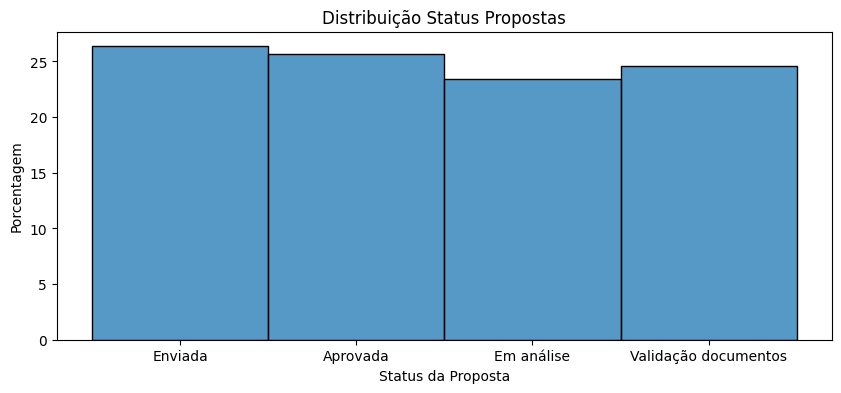

In [472]:
plt.figure(figsize=(10, 4))
sns.histplot(data=propostas_credito, x="status_proposta", stat="percent", bins=20)
plt.title("Distribuição Status Propostas")
plt.xlabel("Status da Proposta")
plt.ylabel("Porcentagem")
plt.show()

#### =============================================================
### 💵 Transações

#### Checagem de nulos

In [473]:
transacoes.isnull().sum()

cod_transacao         0
num_conta             0
data_transacao_raw    0
nome_transacao        0
valor_transacao       0
data_transacao        0
data                  0
mes                   0
par_impar             0
dia_semana            0
dtype: int64

#### Exploração inicial

In [474]:
# transacoes.info()
transacoes.describe()
transacoes.columns

Index(['cod_transacao', 'num_conta', 'data_transacao_raw', 'nome_transacao',
       'valor_transacao', 'data_transacao', 'data', 'mes', 'par_impar',
       'dia_semana'],
      dtype='object')

In [475]:
transacoes["nome_transacao"].value_counts()

nome_transacao
Compra Crédito                      24977
Compra Débito                       17662
Pix - Realizado                     13164
Pix - Recebido                       5134
Depósito em espécie                  4866
Saque                                2879
TED - Recebido                       1005
Pagamento de boleto                   452
Transferência entre CC - Crédito      441
Estorno de Debito                     403
DOC - Recebido                        402
Transferência entre CC - Débito       303
TED - Realizado                       130
DOC - Realizado                        91
Pix Saque                              90
Name: count, dtype: int64

#### Identificação das transações mais comuns

In [476]:
transacoes["nome_transacao"].value_counts()
print(f"As três transações mais comuns são: {', '.join(transacoes['nome_transacao'].value_counts().head(3).index)}.")

As três transações mais comuns são: Compra Crédito, Compra Débito, Pix - Realizado.


#### Análises das transações APROVADAS por dia da semana

In [477]:
# Merge clientes + propostas
clientes_propostas = clientes.merge(propostas_credito[["cod_cliente", "status_proposta"]], on="cod_cliente", how="inner")

# Merge clientes_propostas + contas
clientes_contas = clientes_propostas.merge(contas[["num_conta", "cod_cliente"]], on="cod_cliente", how="inner")

# Merge clientes_propostas + transacoes
transacoes_prop = clientes_contas.merge(transacoes, on="num_conta", how="inner")

In [478]:
# Filtro de transações com status 'Aprovada'
transacoes_aprovadas = transacoes_prop[transacoes_prop["status_proposta"] == "Aprovada"].copy()

# Adiciona coluna com o dia da semana que foi realizada a transação
transacoes_aprovadas.loc[:, "dia_semana"] = transacoes_aprovadas["data_transacao"].dt.day_name() 

In [479]:
# Qtde de transações aprovadas por dia
qtd_transacoes_aprov_dia = transacoes_aprovadas.groupby("dia_semana")["valor_transacao"].count()

# Valor médio aprovado por dia
valor_aprov_dia = transacoes_aprovadas.groupby("dia_semana")["valor_transacao"].mean()

In [480]:
# Reordenando os dias da semana
ordem_semana = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

qtd_transacoes_aprov_dia = qtd_transacoes_aprov_dia.reindex(ordem_semana)

valor_aprov_dia = valor_aprov_dia.reindex(ordem_semana)

# Dicionário para traduzir os dias da semana
dias_semana_pt = {
    "Monday": "Segunda-feira",
    "Tuesday": "Terça-feira",
    "Wednesday": "Quarta-feira",
    "Thursday": "Quinta-feira",
    "Friday": "Sexta-feira",
    "Saturday": "Sábado",
    "Sunday": "Domingo"
}

# Aplicando a tradução nos índices
qtd_transacoes_aprov_dia.index = qtd_transacoes_aprov_dia.index.map(dias_semana_pt)
valor_aprov_dia.index = valor_aprov_dia.index.map(dias_semana_pt)

print(f"Qtde de transações APROVADAS por dia da semana: {qtd_transacoes_aprov_dia}\n\nValor médio movimentado por dia da semana: {round(valor_aprov_dia, 3)}")

Qtde de transações APROVADAS por dia da semana: dia_semana
Segunda-feira     3628
Terça-feira       3851
Quarta-feira      4092
Quinta-feira     13914
Sexta-feira       3631
Sábado            3693
Domingo           3979
Name: valor_transacao, dtype: int64

Valor médio movimentado por dia da semana: dia_semana
Segunda-feira    384.313
Terça-feira      351.792
Quarta-feira     412.379
Quinta-feira     347.981
Sexta-feira      261.400
Sábado           392.004
Domingo          587.698
Name: valor_transacao, dtype: float64


Inferência

In [481]:
print(f"O dia da semana com maior quantidade de transações aprovadas é {qtd_transacoes_aprov_dia.idxmax()} com {qtd_transacoes_aprov_dia.max()} transações.\n\nO dia da semana com maior valor médio movimentado é {valor_aprov_dia.idxmax()} com valor médio de R${valor_aprov_dia.max():.2f}")

O dia da semana com maior quantidade de transações aprovadas é Quinta-feira com 13914 transações.

O dia da semana com maior valor médio movimentado é Domingo com valor médio de R$587.70



#### Comparação de transações em meses PARES X meses ÍMPARES

In [482]:
transacoes["par_impar"].value_counts()

par_impar
Par      47340
Ímpar    24659
Name: count, dtype: int64

In [483]:
# Contagem de transações em meses pares e ímpares
cont_par_impar = transacoes["par_impar"].value_counts()
resultado = cont_par_impar.idxmax()
qtde = cont_par_impar.max()

if resultado == "Par":
    print(f"A quantidade de transações é significamente maior nos meses {resultado}, com média de {round(qtde, 3)} transações. \nIsso consistente com a hipótese levantada.")
else:
    print(f"A quantidade de transações é significamente maior nos meses {resultado}, com média de {round(qtde, 3)} transações. \nIsso não é consistente com a hipótese levantada.")

A quantidade de transações é significamente maior nos meses Par, com média de 47340 transações. 
Isso consistente com a hipótese levantada.


#### Análises usando `dim_dates`
##### Análises nesse bloco
- Quantidade de transações realizadas por mês + Valor médio transacionado por mês
- Comparativo da qtde de transações realizadas aos Fins de Semana X Dias Úteis

##### 1: Quantidade de transações realizadas por mês + valor médio mensal transacionado

In [484]:
# Recriando a dim_dates para garantir que está correta
min_d = transacoes["data"].min()
max_d = transacoes["data"].max()

# Gerando o calendário completo de dias entre min_d e max_d 
dim_dates = pd.DataFrame({"data": pd.date_range(start=min_d, end=max_d, freq="D")})
dim_dates["ano"] = dim_dates["data"].dt.year
dim_dates["mes"] = dim_dates["data"].dt.month
dim_dates["nome_mes"] = dim_dates["data"].dt.month_name()

In [485]:
# Verificação de integridade dos dados antes da agregação 
nat_count = transacoes["data"].isna().sum()
if nat_count > 0:
    print(f"Há {nat_count} transações com data NaT (serão ignoradas na agregação).")

# Verificação de datas em transações que não existem na dim_dates
datas_tx = pd.Series(transacoes["data"].dropna().unique())
datas_dim = pd.Series(dim_dates["data"].unique())
datas_sem_match = pd.to_datetime(pd.Index(datas_tx).difference(pd.Index(datas_dim)))

# Verificação visual das datas que não deram match
if len(datas_sem_match) > 0:
    print("\nDatas presentes em transações e ausentes na dim_dates:")
    print(datas_sem_match.sort_values().to_list())

In [486]:
# Agrupamento diário das transações e merge com dim_dates
transacoes_diaria = (transacoes.dropna(subset=["data"]).groupby("data", as_index=False).agg(qtd=("cod_transacao","size"),valor_liquido=("valor_transacao","sum"),valor_abs=("valor_transacao", lambda s: s.abs().sum())))

# Criação do calendário diário completo com preenchimento de zeros
calendario_diario = (
    dim_dates[["data","ano","mes","nome_mes"]]
      .merge(transacoes_diaria, on="data", how="left", validate="1:1")
      .fillna({"qtd":0, "valor_liquido":0.0, "valor_abs":0.0})
)
# print("Check (qtd somada) -> calendario_diario vs transacoes_diaria:", calendario_diario["qtd"].sum(), "==", transacoes_diaria["qtd"].sum())

In [487]:
# Agregação diária das transações para visão mensal e cálculo do ticket médio (valor médio por transação)
mensal = (
    calendario_diario
      .groupby(["ano","mes","nome_mes"], as_index=False)
      .agg(
          qtd=("qtd","sum"),
          valor_liquido=("valor_liquido","sum"),
          movimentacao_bruta=("valor_abs","sum")
      )
      .sort_values(["ano","mes"])
      .reset_index(drop=True)
)

mensal["ticket_medio"] = ((mensal["valor_liquido"] / mensal["qtd"]).replace([np.inf, -np.inf], np.nan).fillna(0))

In [488]:
for ano, df_ano in mensal.groupby("ano"):
    print(f"\nAno: {ano}")
    for _, r in df_ano.iterrows():
        print(
            f"{r['nome_mes'][:3]} - {int(r['qtd'])} transações "
            f"- Mov.: R${r['movimentacao_bruta']:.2f} "
            f"- Líq.: R${r['valor_liquido']:.2f} "
            f"- Ticket: R${r['ticket_medio']:.2f}"
        )


Ano: 2010
Feb - 2 transações - Mov.: R$474.59 - Líq.: R$116.01 - Ticket: R$58.01
Mar - 8 transações - Mov.: R$2149.64 - Líq.: R$1566.96 - Ticket: R$195.87
Apr - 0 transações - Mov.: R$0.00 - Líq.: R$0.00 - Ticket: R$0.00
May - 2 transações - Mov.: R$156.74 - Líq.: R$15.06 - Ticket: R$7.53
Jun - 6 transações - Mov.: R$10096.34 - Líq.: R$9869.88 - Ticket: R$1644.98
Jul - 6 transações - Mov.: R$917.66 - Líq.: R$270.34 - Ticket: R$45.06
Aug - 9 transações - Mov.: R$503.92 - Líq.: R$10.68 - Ticket: R$1.19
Sep - 20 transações - Mov.: R$18641.94 - Líq.: R$17129.60 - Ticket: R$856.48
Oct - 16 transações - Mov.: R$982.18 - Líq.: R$-484.88 - Ticket: R$-30.30
Nov - 2 transações - Mov.: R$413.38 - Líq.: R$223.62 - Ticket: R$111.81
Dec - 22 transações - Mov.: R$1311.57 - Líq.: R$-50.77 - Ticket: R$-2.31

Ano: 2011
Jan - 21 transações - Mov.: R$102111.99 - Líq.: R$25317.47 - Ticket: R$1205.59
Feb - 8 transações - Mov.: R$2775.26 - Líq.: R$2118.54 - Ticket: R$264.82
Mar - 21 transações - Mov.: R$268

##### 2: Comparativo Quantidade de Transações Fim de Semana X Dias Úteis

In [489]:
# Criação da coluna eh_fds na dim_dates (semana: 5 = Sábado, 6 = Domingo)
transacoes["data"] = pd.to_datetime(transacoes["data_transacao"], errors="coerce").dt.floor("D")
dim_dates["eh_fds"] = dim_dates["data"].dt.dayofweek.isin([5, 6])  


# Agregando a quantidade de transações por dia 
qtd_dia = (transacoes.groupby("data", as_index=False).agg(qtd=("cod_transacao","size")))

# Merge com o calendário diário para garantir todos os dias
base_diaria = (dim_dates[["data","eh_fds"]].merge(qtd_dia, on="data", how="left", validate="1:1").fillna({"qtd":0}))

# Agregação por período (Dias Úteis vs Fim de Semana) e reindexação para garantir a ordem
qtd_por_periodo = (
    base_diaria
      .groupby("eh_fds", as_index=False)
      .agg(qtd=("qtd","sum"))
      .set_index("eh_fds")
      # False = Dias Úteis, True = Fim de Semana
      .reindex([False, True], fill_value=0)  
      .rename(index={False:"Dias Úteis", True:"Fim de Semana"})
      .reset_index(names="periodo")
)

print(f"\nQuantidade de transações — Dias Úteis vs Fim de Semana:\n{qtd_por_periodo}")



Quantidade de transações — Dias Úteis vs Fim de Semana:
         periodo      qtd
0     Dias Úteis  57185.0
1  Fim de Semana  14814.0


Visualização dos Dados

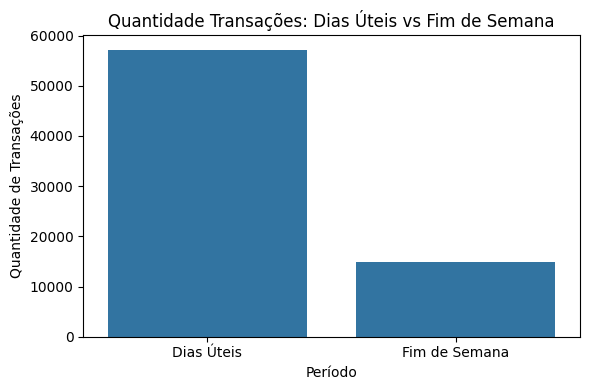

In [490]:
plt.figure(figsize=(6,4))
sns.barplot(data=qtd_por_periodo, x="periodo", y="qtd")
plt.title("Quantidade Transações: Dias Úteis vs Fim de Semana")
plt.xlabel("Período")
plt.ylabel("Quantidade de Transações")
plt.tight_layout()
plt.show()

Inferência

In [491]:
# Análise da diferença de quantidade de transações entre dias úteis e fins de semana
q_uteis = qtd_por_periodo.loc[qtd_por_periodo["periodo"]=="Dias Úteis","qtd"].iloc[0]
q_fds   = qtd_por_periodo.loc[qtd_por_periodo["periodo"]=="Fim de Semana","qtd"].iloc[0]

diferenca_qtde_fds = q_uteis - q_fds

print(f"Pode-se ver que a quantidade de transações realizadas em dias úteis é significativamente maior do que em fins de semana, com diferença de {diferenca_qtde_fds} transações.")

Pode-se ver que a quantidade de transações realizadas em dias úteis é significativamente maior do que em fins de semana, com diferença de 42371.0 transações.


#### =============================================================
### 💲 Integração com Dados Externos - Cotação Dólar USD

In [492]:
# Merge de USD diário com base calendarizada
base_calendario = (dim_dates.merge(fx_dia, on="data", how="left")
                    .merge(calendario_diario[["data","qtd","valor_liquido","valor_abs"]],
                           on="data", how="left")
                    .fillna({"qtd":0,"valor_liquido":0.0,"valor_abs":0.0}))

In [493]:
# Cálculo do Retorno Diário e Volatilidade de 7 dias 
base_calendario["usd_ret"] = base_calendario["usd_ptax"].pct_change()
base_calendario["usd_vol_7d"] = base_calendario["usd_ret"].rolling(7, min_periods=5).std()

In [494]:
# Exibição das Correlações 
print("corr(qtd, usd):", base_calendario["qtd"].corr(base_calendario["usd_ptax"]))
print("corr(mov_bruta, usd):", base_calendario["valor_abs"].corr(base_calendario["usd_ptax"]))
print("corr(qtd, vol_7d):", base_calendario["qtd"].corr(base_calendario["usd_vol_7d"]))
print("corr(mov_bruta, vol_7d):", base_calendario["valor_abs"].corr(base_calendario["usd_vol_7d"]))

print("\nNão há correlação forte entre câmbio e transações.")

corr(qtd, usd): -0.0957252139957423
corr(mov_bruta, usd): 0.18013497039032497
corr(qtd, vol_7d): -0.050083681192185564
corr(mov_bruta, vol_7d): -0.05028675803637948

Não há correlação forte entre câmbio e transações.


Consolidação Mensal
- Soma das transações
- Valor da movimentação bruta
- Média mensal e volatilidade do dólar (USD)

In [495]:
mensal_calendario = (base_calendario
                     .query("data >= '2022-01-01' and data <= '2023-12-31'")
                     .assign(ano=lambda d: d["data"].dt.year,
                             mes=lambda d: d["data"].dt.month)
                     .groupby(["ano","mes"], as_index=False)
                     .agg(qtd=("qtd","sum"),
                          mov_bruta=("valor_abs","sum"),
                          usd_medio=("usd_ptax","mean"),
                          usd_vol_m=("usd_ret","std")))

print(mensal_calendario[["ano","mes","qtd","mov_bruta","usd_medio","usd_vol_m"]].head())

    ano  mes    qtd  mov_bruta  usd_medio  usd_vol_m
0  2022    1  772.0  914974.88   5.534105   0.006075
1  2022    2  621.0  442732.63   5.196579   0.006347
2  2022    3  919.0  481031.41   4.968382   0.007306
3  2022    4  790.0  375647.88   4.758016   0.010466
4  2022    5  825.0  885850.03   4.990379   0.007845


In [496]:
print(transacoes["num_conta"].nunique(), "contas únicas em transações")
print(contas["num_conta"].nunique(), "contas únicas na base contas")


999 contas únicas em transações
999 contas únicas na base contas


#### =============================================================
### 📊 Dashboards (Visualizações Finais)

#### 📈 KPIs

In [497]:
print("====== KPIs BANVIC ======\n")

# Qtde total de transações 
kpi_volume_transacoes = transacoes["cod_transacao"].count()
print(f"🔹 Quantidade total de transações: {kpi_volume_transacoes}")

# Total de valores transacionados
kpi_valor_total = transacoes["valor_transacao"].sum()
print(f"🔹 Valor total transacionado: R${kpi_valor_total:.2f}")

# Valor médio das transações
kpi_valor_medio = transacoes["valor_transacao"].mean()
print(f"🔹 Valor médio das transações: R${round(kpi_valor_medio, 2)}")

# Taxa de aprovação de propostas de crédito ("Aprovada")
kpi_taxa_aprovacao = (propostas_credito["status_proposta"].value_counts(normalize=True).get("Aprovada", 0)) * 100
print(f"🔹 Taxa de aprovação de propostas de crédito: {kpi_taxa_aprovacao:.2f}%")

# Número de clientes ÚNICOS
kpi_clientes_unicos = clientes["cod_cliente"].nunique()
print(f"🔹 Número de clientes únicos: {kpi_clientes_unicos}")

# Número de agências ÚNICAS
kpi_agencias_unicas = agencias["cod_agencia"].nunique()
print(f"🔹 Número de agências únicas: {kpi_agencias_unicas}")

print(f"\nOs indicadores mostram um total de {kpi_volume_transacoes} transações, com valor total de R${kpi_valor_total:.2f} e valor médio de R${round(kpi_valor_medio, 2)} por transação.\nA taxa de aprovação de propostas de crédito é de {kpi_taxa_aprovacao:.2f}%.\nAlém disso, há {kpi_clientes_unicos} clientes únicos e {kpi_agencias_unicas} agências únicas.")

====== KPIs BANVIC ======

🔹 Quantidade total de transações: 71999
🔹 Valor total transacionado: R$25705454.40
🔹 Valor médio das transações: R$357.03
🔹 Taxa de aprovação de propostas de crédito: 25.70%
🔹 Número de clientes únicos: 998
🔹 Número de agências únicas: 10

Os indicadores mostram um total de 71999 transações, com valor total de R$25705454.40 e valor médio de R$357.03 por transação.
A taxa de aprovação de propostas de crédito é de 25.70%.
Além disso, há 998 clientes únicos e 10 agências únicas.


#### 🏦 Análise de Agências

##### TODO O PERIODO: Top 10 Agências com Mais Transações 

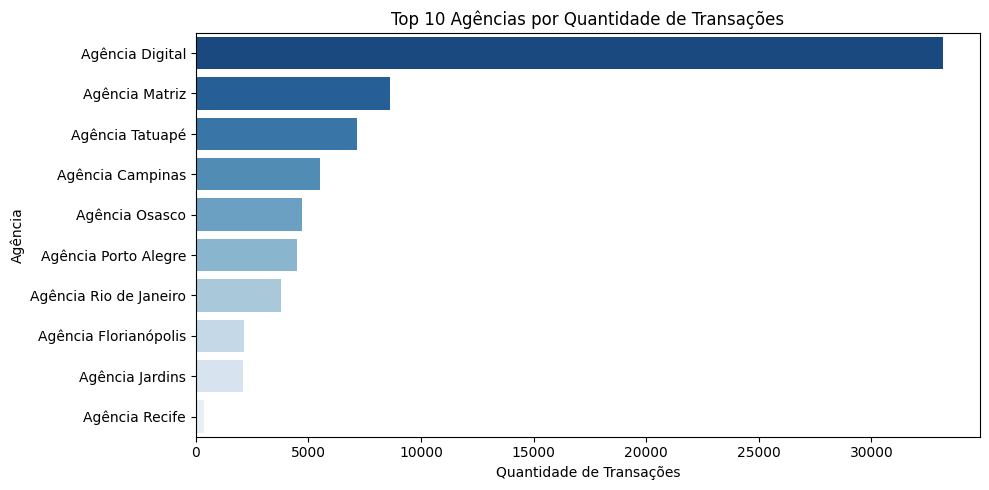

A agência com mais transações é Agência Digital com 33167 transações.
A agência com menos transações entre as top 10 é Agência Recife com 374 transações.


In [498]:
top_agencias = ranking_agencias.nlargest(10, "qtd_transacoes")
plt.figure(figsize=(10,5))
sns.barplot(data=top_agencias, x="qtd_transacoes", y="nome", palette="Blues_r")
plt.title("Top 10 Agências por Quantidade de Transações")
plt.xlabel("Quantidade de Transações")
plt.ylabel("Agência")
plt.tight_layout()
plt.savefig("../img/graficos/dash_top_agencias.png")
plt.show()

print(f"A agência com mais transações é {top_agencias.iloc[0]['nome']} com {top_agencias.iloc[0]['qtd_transacoes']} transações.")
print(f"A agência com menos transações entre as top 10 é {top_agencias.iloc[-1]['nome']} com {top_agencias.iloc[-1]['qtd_transacoes']} transações.")

##### ÚLTIMOS 6 MESES: Top 10 Agências com Mais Transações

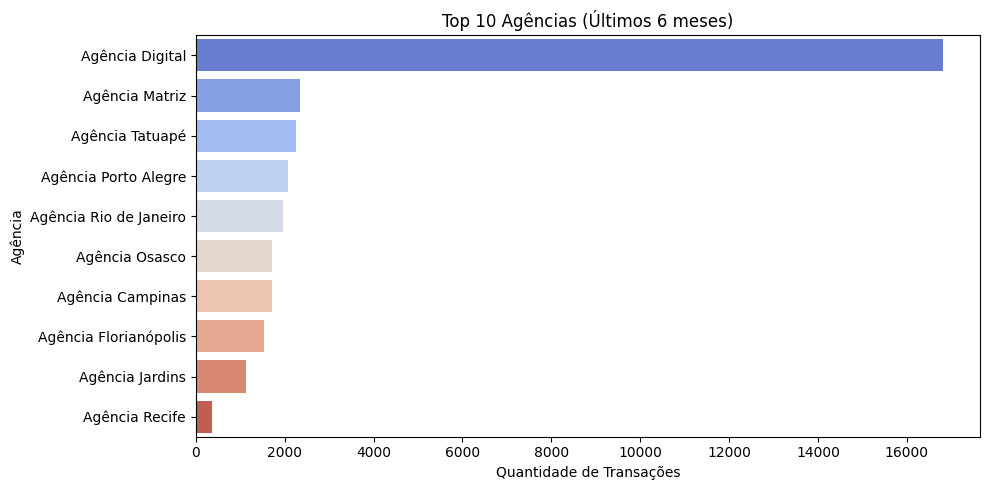

A agência com mais transações nos últimos 6 meses é Agência Digital com 16806 transações.


In [499]:
top_agencias_6m = ranking_agencias_6m.nlargest(10, "qtd_transacoes")
plt.figure(figsize=(10,5))
sns.barplot(data=top_agencias_6m, x="qtd_transacoes", y="nome", palette="coolwarm")
plt.title("Top 10 Agências (Últimos 6 meses)")
plt.xlabel("Quantidade de Transações")
plt.ylabel("Agência")
plt.tight_layout()
plt.savefig("../img/graficos/dash_top_agencias_6m.png")
plt.show()

print(f"A agência com mais transações nos últimos 6 meses é {top_agencias_6m.iloc[0]['nome']} com {top_agencias_6m.iloc[0]['qtd_transacoes']} transações.")

#### 👥  Análise dos Clientes

Distribuição de Idade dos Clientes

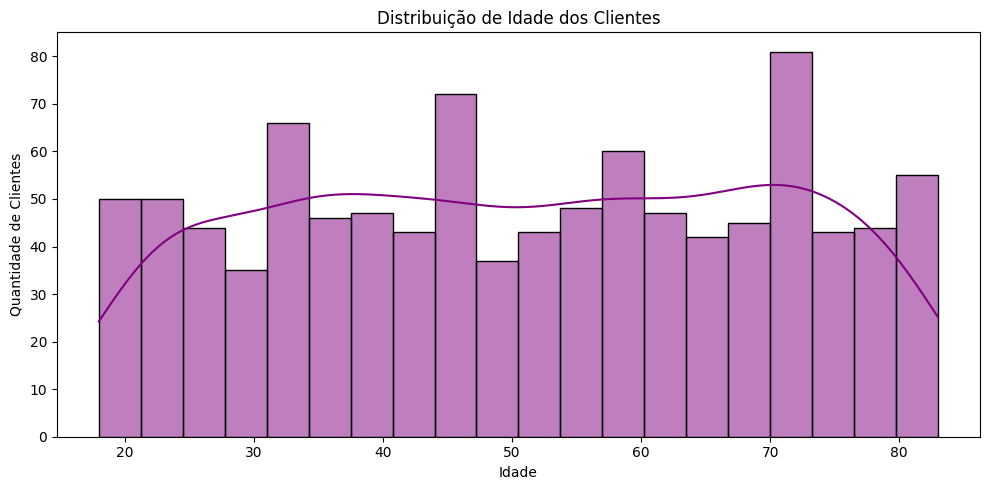

A maioria dos clientes aparenta estar principalmente entre 30 e 50 anos, com outro pico relevante na faixa dos 70 anos. Mediana: 51.0 anos.


In [500]:
plt.figure(figsize=(10,5))
sns.histplot(data=clientes, x="idade", bins=20, kde=True, color="purple")
plt.title("Distribuição de Idade dos Clientes")
plt.xlabel("Idade")
plt.ylabel("Quantidade de Clientes")
plt.tight_layout()
plt.savefig("../img/graficos/dash_idade_clientes.png")
plt.show()

print(f"A maioria dos clientes aparenta estar principalmente entre 30 e 50 anos, com outro pico relevante na faixa dos 70 anos. Mediana: {clientes['idade'].median()} anos.")

Quantidade de Clientes por Estado

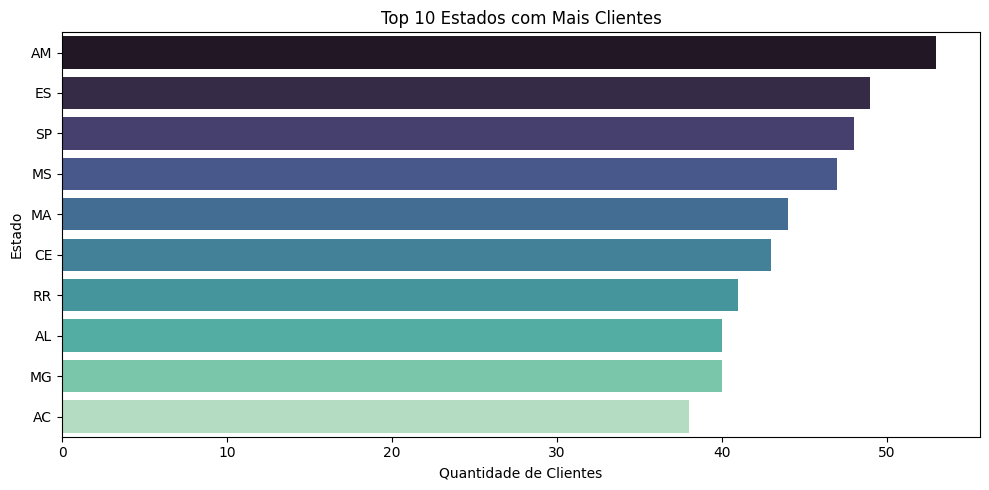

O estado com mais clientes é AM com 53 clientes.


In [501]:
clientes_estado = clientes["estado"].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=clientes_estado.values, y=clientes_estado.index, palette="mako")
plt.title("Top 10 Estados com Mais Clientes")
plt.xlabel("Quantidade de Clientes")
plt.ylabel("Estado")
plt.tight_layout()
plt.savefig("../img/graficos/dash_clientes_estado.png")
plt.show()

print(f"O estado com mais clientes é {clientes['estado'].value_counts().idxmax()} com {clientes['estado'].value_counts().max()} clientes.")

#### 💳 Análise de Contas

Distribuição do Saldo Total

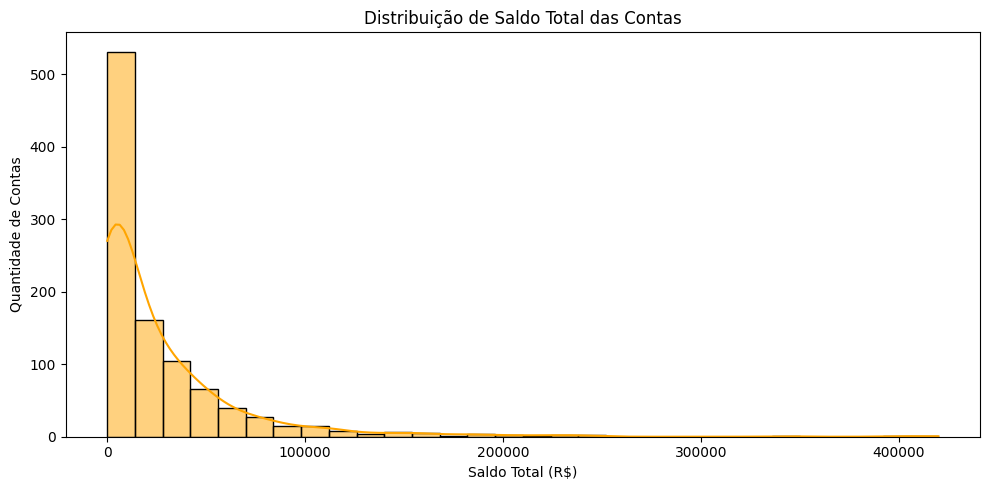

O saldo médio das contas é de R$26543.41


In [502]:
plt.figure(figsize=(10,5))
sns.histplot(contas["saldo_total"], bins=30, kde=True, color="orange")
plt.title("Distribuição de Saldo Total das Contas")
plt.xlabel("Saldo Total (R$)")
plt.ylabel("Quantidade de Contas")
plt.tight_layout()
plt.savefig("../img/graficos/dash_saldo_contas.png")
plt.show()

print(f"O saldo médio das contas é de R${contas['saldo_total'].mean():.2f}")

#### 💰 Análise das Propostas de Crédito

##### Status das Propostas

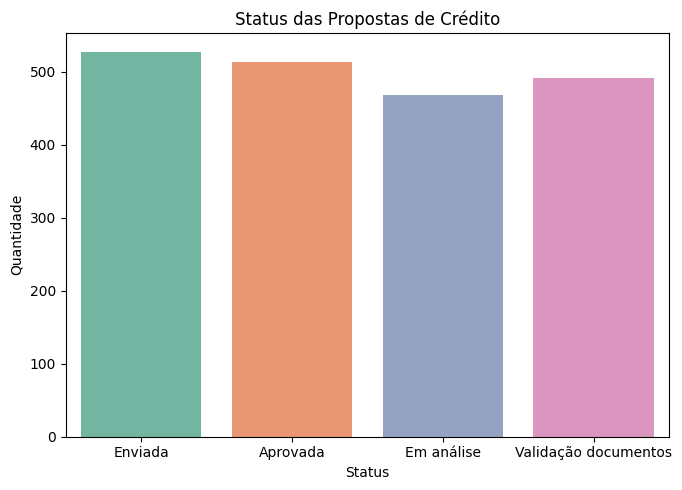

A taxa de aprovação das propostas de crédito é de 25.70%


In [503]:
plt.figure(figsize=(7,5))
sns.countplot(data=propostas_credito, x="status_proposta", palette="Set2")
plt.title("Status das Propostas de Crédito")
plt.xlabel("Status")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.savefig("../img/graficos/dash_status_propostas.png")
plt.show()

print(f"A taxa de aprovação das propostas de crédito é de {kpi_taxa_aprovacao:.2f}%")

##### Distribuição do Valor das Propostas

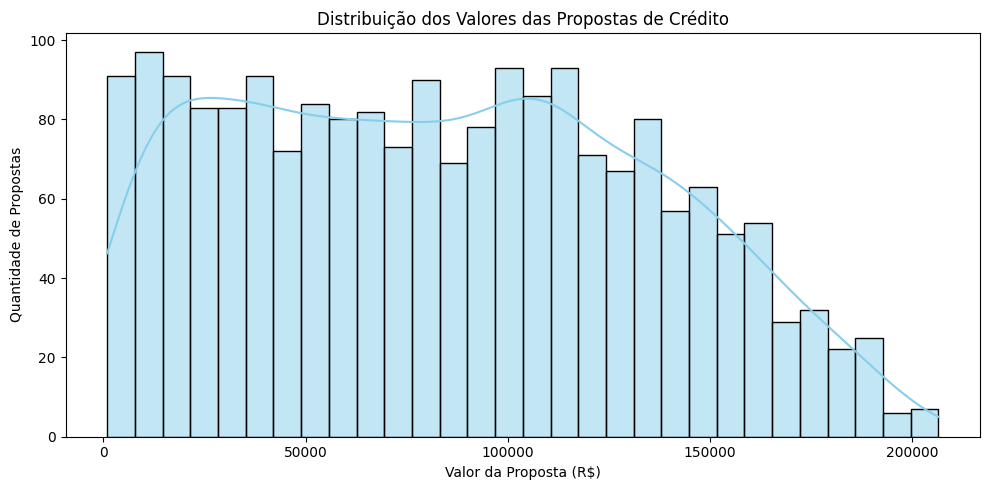

O valor médio das propostas é de R$83890.49
A moda das propostas é de R$944.01


In [504]:
plt.figure(figsize=(10,5))
sns.histplot(propostas_credito["valor_proposta"], bins=30, kde=True, color="skyblue")
plt.title("Distribuição dos Valores das Propostas de Crédito")
plt.xlabel("Valor da Proposta (R$)")
plt.ylabel("Quantidade de Propostas")
plt.tight_layout()
plt.savefig("../img/graficos/dash_valor_propostas.png")
plt.show()

print(f"O valor médio das propostas é de R${propostas_credito['valor_proposta'].mean():.2f}")
print(f"A moda das propostas é de R${propostas_credito['valor_proposta'].mode()[0]:.2f}")

#### 💵 Análise das Transações

##### Quantidade de Transações por Mês

In [505]:
mapa_meses = {
    "January": "Janeiro", "February": "Fevereiro", "March": "Março",
    "April": "Abril", "May": "Maio", "June": "Junho",
    "July": "Julho", "August": "Agosto", "September": "Setembro",
    "October": "Outubro", "November": "Novembro", "December": "Dezembro"
}

mensal["nome_mes"] = mensal["nome_mes"].replace(mapa_meses)

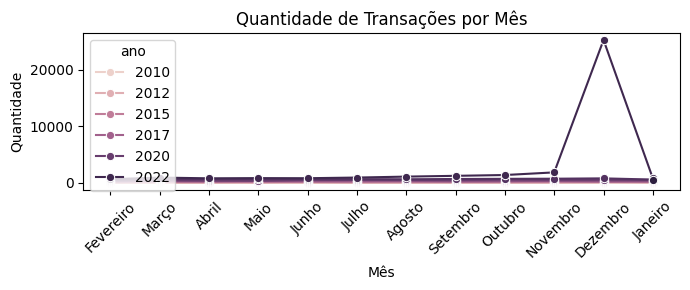

O mês com mais transaçõs foi Dezembro de 2022 com 25310.0 transações.


In [516]:
plt.figure(figsize=(7,3))
sns.lineplot(data=mensal, x="nome_mes", y="qtd", hue="ano", marker="o")
plt.title("Quantidade de Transações por Mês")
plt.xlabel("Mês")
plt.ylabel("Quantidade")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../img/graficos/dash_transacoes_mes.png")
plt.show()

print(f"O mês com mais transaçõs foi {mensal.loc[mensal['qtd'].idxmax()]['nome_mes']} de {mensal.loc[mensal['qtd'].idxmax()]['ano']} com {mensal['qtd'].max()} transações.")

##### Transações Aprovadas por Dia da Semana

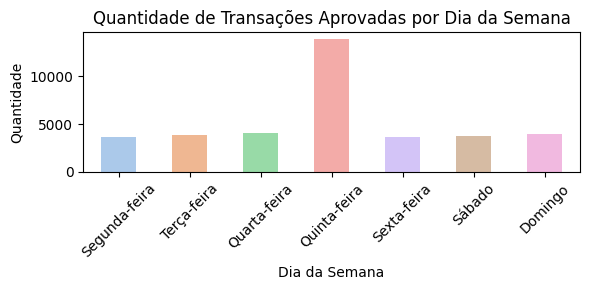

O dia da semana com maior quantidade de transações aprovadas é Quinta-feira com 13914 transações.


In [523]:
plt.figure(figsize=(6,3))
sns.barplot(x=qtd_transacoes_aprov_dia.index, y=qtd_transacoes_aprov_dia.values, palette="pastel", width=0.5)
plt.title("Quantidade de Transações Aprovadas por Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Quantidade")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../img/graficos/dash_transacoes_semana.png")
plt.show()

print(f"O dia da semana com maior quantidade de transações aprovadas é {qtd_transacoes_aprov_dia.idxmax()} com {qtd_transacoes_aprov_dia.max()} transações.")


##### Comparativo: Qtde de Transações Dias Úteis X Fim de Semana

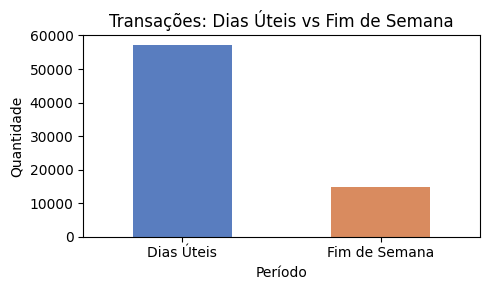

Pode-se ver que a quantidade de transações realizadas em dias úteis é significativamente maior do que em fins de semana, com diferença de 42371.0 transações.


In [525]:
plt.figure(figsize=(5,3))
sns.barplot(data=qtd_por_periodo, x="periodo", y="qtd", palette="muted", width=0.5)
plt.title("Transações: Dias Úteis vs Fim de Semana")
plt.xlabel("Período")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.savefig("../img/graficos/dash_fds_vs_uteis.png")
plt.show()

print(f"Pode-se ver que a quantidade de transações realizadas em dias úteis é significativamente maior do que em fins de semana, com diferença de {diferenca_qtde_fds} transações.")

#### 💲 Análise Cotação do Dólar USD

 Correlação câmbio com a movimentação bruta

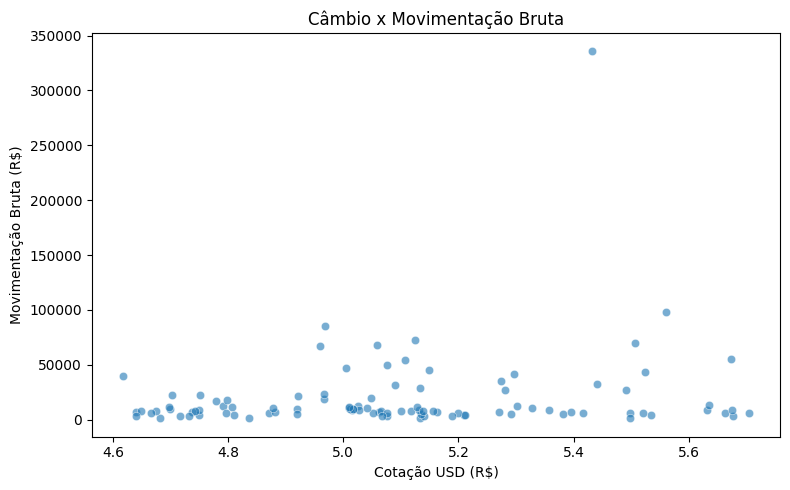

Pode-se observar que não há uma correlação forte entre a cotação do dólar e a movimentação bruta diária. Isso sugere que outros fatores além do câmbio influenciam o volume de transações no banco.


In [509]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=base_calendario, x="usd_ptax", y="valor_abs", alpha=0.6)
plt.title("Câmbio x Movimentação Bruta")
plt.xlabel("Cotação USD (R$)")
plt.ylabel("Movimentação Bruta (R$)")
plt.tight_layout()
plt.savefig("../img/graficos/dash_cambio_mov.png")
plt.show()

print("Pode-se observar que não há uma correlação forte entre a cotação do dólar e a movimentação bruta diária. Isso sugere que outros fatores além do câmbio influenciam o volume de transações no banco.")